# Hybrid quantum-classical Neural Networks with PyTorch and Qiskit

We are goging to use FASHIONMNIST to diferenciate a T-shirt/top
from a Trouser.

## 3. Let's code! <a id='code'></a>


### 3.1 Imports <a id='imports'></a>
First, we import some handy packages that we will need, including Qiskit and PyTorch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

### 3.2 Create a "Quantum Class" with Qiskit <a id='q-class'></a>
We can conveniently put our Qiskit quantum functions into a class. First, we specify how many trainable quantum parameters and how many shots we wish to use in our quantum circuit. In this example, we will keep it simple and use a 1-qubit circuit with one trainable quantum parameter $\theta$. We hard code the circuit for simplicity and use a $RY-$rotation by the angle $\theta$ to train the output of our circuit. The circuit looks like this:

<img src="1qubitcirc.png" width="400"/>

In order to measure the output in the $z-$basis, we calculate the $\sigma_\mathbf{z}$ expectation. 
$$\sigma_\mathbf{z} = \sum_i z_i p(z_i)$$
We will see later how this all ties into the hybrid neural network.

In [2]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

Let's test the implementation

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Expected value for rotation pi 0.47


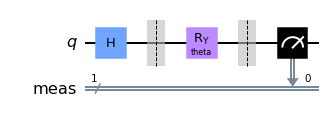

In [3]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

### 3.3 Create a "Quantum-Classical Class" with PyTorch <a id='qc-class'></a>
Now that our quantum circuit is defined, we can create the functions needed for backpropagation using PyTorch. [The forward and backward passes](http://www.ai.mit.edu/courses/6.034b/backprops.pdf) contain elements from our Qiskit class. The backward pass directly computes the analytical gradients using the finite difference formula we introduced above.

In [4]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

### 3.4 Data Loading and Preprocessing <a id='data-loading-preprocessing'></a>
##### Putting this all together:
We will create a simple hybrid neural network to classify images of two types of digits (0 or 1) from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). We first load MNIST and filter for pictures containing 0's and 1's. These will serve as inputs for our neural network to classify.

#### Training data

In [5]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.FashionMNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

28


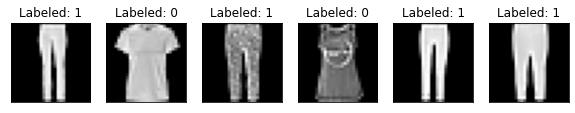

In [6]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1
print(images.shape[2])

#### Testing data

In [7]:
n_samples = 50

X_test = datasets.FashionMNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

So far, we have loaded the data and coded a class that creates our quantum circuit which contains 1 trainable parameter. This quantum parameter will be inserted into a classical neural network along with the other classical parameters to form the hybrid neural network. We also created backward and forward pass functions that allow us to do backpropagation and optimise our neural network. Lastly, we need to specify our neural network architecture such that we can begin to train our parameters using optimisation techniques provided by PyTorch. 


### 3.5 Creating the Hybrid Neural Network <a id='hybrid-nn'></a>
We can use a neat PyTorch pipeline to create a neural network architecture. The network will need to be compatible in terms of its dimensionality when we insert the quantum layer (i.e. our quantum circuit). Since our quantum  in this example contains 1 parameter, we must ensure the network condenses neurons down to size 1. We create a typical Convolutional Neural Network with two fully-connected layers at the end. The value of the last neuron of the fully-connected layer is fed as the parameter $\theta$ into our quantum circuit. The circuit measurement then serves as the final prediction for 0 or 1 as provided by a $\sigma_z$ measurement.

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)


### 3.6 Training the Network <a id='training'></a>
We now have all the ingredients to train our hybrid network! We can specify any [PyTorch optimiser](https://pytorch.org/docs/stable/optim.html), [learning rate](https://en.wikipedia.org/wiki/Learning_rate) and [cost/loss function](https://en.wikipedia.org/wiki/Loss_function) in order to train over multiple epochs. In this instance, we use the [Adam optimiser](https://arxiv.org/abs/1412.6980), a learning rate of 0.001 and the [negative log-likelihood loss function](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html).

In [9]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

/tmp/ipykernel_97051/2571825612.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  result = torch.tensor([expectation_z])
/tmp/ipykernel_97051/2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.7297
Training [10%]	Loss: -0.8845
Training [15%]	Loss: -0.9055
Training [20%]	Loss: -0.9245
Training [25%]	Loss: -0.9161
Training [30%]	Loss: -0.9367
Training [35%]	Loss: -0.9402
Training [40%]	Loss: -0.9421
Training [45%]	Loss: -0.9500
Training [50%]	Loss: -0.9568
Training [55%]	Loss: -0.9496
Training [60%]	Loss: -0.9631
Training [65%]	Loss: -0.9694
Training [70%]	Loss: -0.9711
Training [75%]	Loss: -0.9777
Training [80%]	Loss: -0.9755
Training [85%]	Loss: -0.9821
Training [90%]	Loss: -0.9789
Training [95%]	Loss: -0.9793
Training [100%]	Loss: -0.9812


Plot the training graph

Text(0, 0.5, 'Neg Log Likelihood Loss')

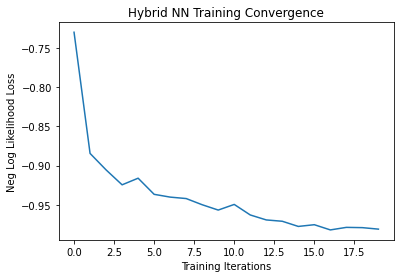

In [11]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

### 3.7 Testing the Network <a id='testing'></a>

In [12]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.9813
	Accuracy: 100.0%


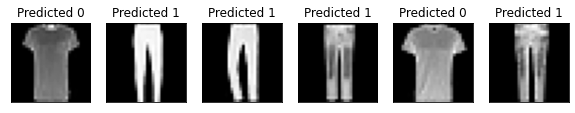

In [13]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

## 4. What Now? <a id='what-now'></a>

#### While it is totally possible to create hybrid neural networks, does this actually have any benefit? 

In fact, the classical layers of this network train perfectly fine (in fact, better) without the quantum layer. Furthermore, you may have noticed that the quantum layer we trained here **generates no entanglement**, and will, therefore, continue to be classically simulatable as we scale up this particular architecture. This means that if you hope to achieve a quantum advantage using hybrid neural networks, you'll need to start by extending this code to include a more sophisticated quantum layer. 


The point of this exercise was to get you thinking about integrating techniques from ML and quantum computing in order to investigate if there is indeed some element of interest - and thanks to PyTorch and Qiskit, this becomes a little bit easier. 

In [13]:
import qiskit.tools.jupyter
%qiskit_version_table